Extracting the data using Pandas, cleaning it and setting the severity levels for the candidate's event for predictions.

In [1]:
import pandas as pd
import numpy as np
df = pd.read_excel(r'CAT_Training_Dataset_V3 File.xlsx')
candidate = "ABCDE00002"  # The candidate we are interested in
event = "Component2_discreteSensorH_Up"  # The event we are interested in

# Data cleaning
df_interested = df[df["event"]==event].copy() #It contains the event Component2_discreteSensorH_Up
# Clear errors and then we need to sort it according to the chronological order (date column)
df_interested.drop(columns=["ID",], inplace=True)
#print(df_interested)
df_interested.drop_duplicates(inplace=True)
df_interested = df_interested[df_interested.date.apply(lambda x: str(x).isnumeric())].copy()
#print(df_interested)
df_interested = df_interested[df_interested.occur_count.apply(lambda x: int(x)>0)].copy()
#print(df_interested)
df_interested = df_interested[df_interested.candidate.apply(lambda x: x==candidate)].copy()
df_interested.reset_index(inplace=True, drop=True)
'''
print(df_interested)
print(df_interested.describe())
'''

maxvalues = list()
sevlist, sevandindlist = list(), list()
Y = df_interested['units'].tolist()
X = df_interested['date'].tolist()
z = df_interested['occur_count'].tolist()
for i in range(len(z)):
    Y[i]=Y[i]*z[i]
max_unit = max(Y)
for i in range(len(Y)):
    if(Y[i]==max_unit):
        maxvalues.append(int(i))
for j in maxvalues:
    sevandindlist.append([j, int(df_interested["svrty_level"].iloc[j])])
    sevlist.append(int(df_interested["svrty_level"].iloc[j]))
max_sev = max(sevlist)
all_sevlist = df_interested["svrty_level"].tolist()
cur_sev = all_sevlist[len(all_sevlist)-1] # The current severity level
X, Y = np.array(X), np.array(Y)



indofsev = sevandindlist[sevlist.index(max_sev)][0] 
if(max_sev==1):
    Y_threshold = Y[indofsev]*1.15 #15%
elif(max_sev==2):
    Y_threshold = Y[indofsev]*1.30 #30%
else:
    Y_threshold = Y[indofsev]*1.45 #severity level is 3 -> 45%

#Severity level grouping
severitylist = list()
c = list()
for i in range(1,4):
    a = df_interested['units'][df_interested['svrty_level']==i].tolist()
    b = df_interested['occur_count'][df_interested['svrty_level']==i].tolist()
    if(len(a)!=0):
        for i in range(len(a)):
            c.append(a[i]*b[i])
        severitylist.append(c)
    else:
        severitylist.append(a)


s3 = 0
check = 0

# Dynamically setting the severity levels s1 and s2.
if(len(severitylist[0])!=0 and len(severitylist[1])!=0 and len(severitylist[2])!=0):
    s1 = ( min(severitylist[0]) + max(severitylist[1]) )/2
    s2 = ( min(severitylist[1]) + max(severitylist[2]) )/2
elif(len(severitylist[0])==0 and len(severitylist[1])!=0 and len(severitylist[2])!=0):
    s1 = max(severitylist[1])
    s2 = ( min(severitylist[1]) + max(severitylist[2]) )/2
elif(len(severitylist[0])!=0 and len(severitylist[1])==0 and len(severitylist[2])!=0):
    s1 = min(severitylist[0])
    s2 = max(severitylist[2])
elif(len(severitylist[0])==0 and len(severitylist[1])==0 and len(severitylist[2])!=0):
    s2 = max(severitylist[2])
    s1 = 2*s2
elif(len(severitylist[0])!=0 and len(severitylist[1])!=0 and len(severitylist[2])==0):
    s1 = ( min(severitylist[0]) + max(severitylist[1]) )/2
    s2 = min(severitylist[1])
elif(len(severitylist[0])==0 and len(severitylist[1])!=0 and len(severitylist[2])==0):
    s2 = min(severitylist[1])
    s1 = max(severitylist[1])
elif(len(severitylist[0])!=0 and len(severitylist[1])==0 and len(severitylist[2])==0):
    s1 = min(severitylist[0])
    s2 = s1/2



Using the data extracted from the previous cell to predict when we need to replace the component associated with the sensor before the breakpoint

0.3189452264588152


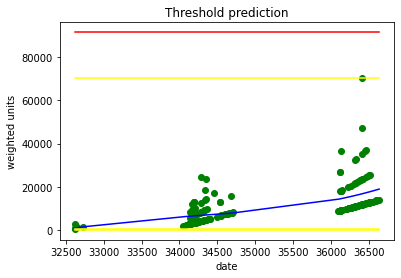

Candidate: ABCDE00002
Event(sensor): Component2_discreteSensorH_Up

---------------------------------
The date when threshold is hit:  39572

The date when severity level reaches 1 : 39040
The current severity level is: 2
Criticality: Moderately critical
Replace the candidate within 2936 dates


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from intropandas import X, Y, Y_threshold, s1, s2, s3, max_sev, cur_sev, candidate, event
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, accuracy_score

max_sev_list = list()
s1lis, s2lis, s3lis = list(), list(), list()
s = [s1, s2, s3]
#Preparing the constant value for to be plotted.
for i in range(len(X)):
    max_sev_list.append(Y_threshold)
    s1lis.append(s1)
    s2lis.append(s2)
    s3lis.append(s3)

max_sev_list = np.array(max_sev_list)
s1lis, s2lis, s3lis = np.array(s1lis), np.array(s2lis), np.array(s3lis),

# Visualizing the Polymonial Regression results
def viz_polymonial():
    #This function is used for drawing the prediction graph which is our units (Y) vs date (X) 
    X1 = list()
    for i in X:
        temp = np.array([i,])
        X1.append(temp)
    Y1 = Y
    try:
        X_train, X_test, Y_train, Y_test = train_test_split(X1, Y1, test_size=0.2, random_state=0)
    except:
        print("Insufficient number of samples for regression analysis.")
        return
    poly_reg = PolynomialFeatures(degree=4)
    X_poly1 = poly_reg.fit_transform(X1)
    pol_reg = LinearRegression()
    pol_reg.fit(X_poly1, Y1)
    score = r2_score(Y, pol_reg.predict(poly_reg.fit_transform(X1)))
    print(score)
    plt.scatter(X1, Y1, color='green')
    plt.plot(X1, pol_reg.predict(poly_reg.fit_transform(X1)), color='blue')
    
    plt.plot(X1, max_sev_list, color='red')
    for i in s1lis, s2lis, s3lis:
        plt.plot(X1, i, color='yellow')
    
    plt.title('Threshold prediction')
    plt.xlabel('date')
    plt.ylabel('weighted units')
    plt.show()
    
    fin_date = X1[len(X1)-1][0]
    i = fin_date
    reachdate_list = [None, None, None]
    end_list = [False, False, False]
    
    
    if(pol_reg.predict(poly_reg.fit_transform( [[ i ]]) )) > pol_reg.predict(poly_reg.fit_transform( [[ i+4 ]]) ):
        print("The candidate can be operated safely because the severity level is decreasing and replacement can be done after many dates.")
    else:
        while pol_reg.predict(poly_reg.fit_transform( [[ i ]]) )<Y_threshold:
            pred_val = pol_reg.predict(poly_reg.fit_transform( [[ i ]]) )
            for j in range(cur_sev-1):
                if(pred_val>s[j] and end_list[j]==False):
                    reachdate_list[j] = i
                    end_list[j] = True
            i+=4
        #print(r2_score(Y1, pol_reg.predict(poly_reg.fit_transform( X1)) ))   
        print("Candidate:", candidate)
        print("Event(sensor):", event)
        print("\n---------------------------------\n\
The date when threshold is hit: ", i)
        threshold_date = i
        for i in range(cur_sev-1): 
            if(i==0):
                print("")
            print("The date when severity level reaches {} : {}".format(i+1, reachdate_list[i]))
        print("The current severity level is:", cur_sev)
        print("Criticality:", end=" ")
        replace_within = threshold_date - fin_date
        if(cur_sev==3):
            print("Minor")
        if(cur_sev==2):
            print("Moderately critical")
            print("Replace the candidate within", replace_within, "dates")
        if(cur_sev==1):
            print("Highly critical")
            print("Replace the candidate within", replace_within, "dates")
    return

    

viz_polymonial() # -> Function call for regressional analysis.


